# Lab Assignment Two: Exploring Table Data

CS 7324

2021-03-07

Anthony Wang

## Business Understanding

[This image dataset](https://www.kaggle.com/crowww/a-large-scale-fish-dataset) is a collection of pictures taken of nine types of seafood in a Turkish supermarket. The seafood include gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, black sea sprat, striped red mullet, trout, and shrimp. The dataset contains one thousand 590 px by 445 px images of of each, but this analysis will use only two hundred images of each type due to memory limitations and for the sake of computational timeliness.

[These pictures were taken specifically for feature extracdtion and species classification purposes](https://ieeexplore.ieee.org/abstract/document/9259867), and that is what this analysis will do. Such data could be used to develop machinery that could automatically sort fish using cameras. This would be useful to markets and fisheries which would need to dedicated less workers to manually sorting fish. In this use case, any classification accuracy better than randomness would be useful. Time spent correcting misclassifications would still be less than the time spent inspecting every single fish. If a model works well enough to identify live fish in their aquatic environment, biologists could use images taken in oceans and seas to estimate fish populations and do what they will with that information. Again, as long as classification accuracy is an improvement over random classification, there would be a time benefit to using such a model.

## Data Preparation

There are a total of 1800 images evenly distributed between 9 categories. Each is scaled to half of its original length and height to a resolution of 295 px by 222 px. The images are then vectorized into an array of length 787650 with preserved color channels.

Loading Black Sea Sprat images...



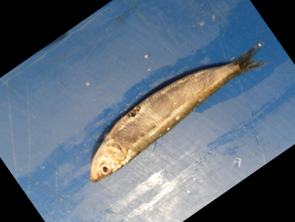

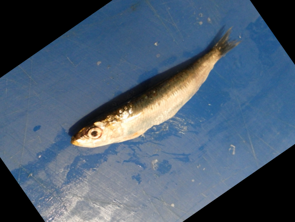



Loading Gilt-Head Bream images...



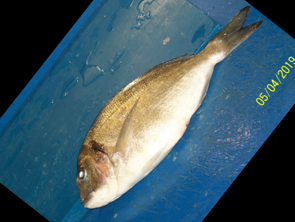

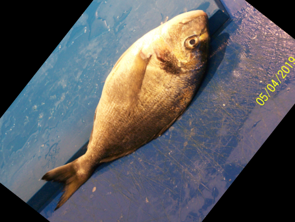

In [1]:
import numpy
from PIL import Image
import requests
from IPython.display import display

fish_types = [
    "Black Sea Sprat",
    "Gilt-Head Bream",
    "Horse Mackerel",
    "Red Mullet",
    "Red Sea Bream",
    "Sea Bass",
    "Shrimp",
    "Striped Red Mullet",
    "Trout"
]

dataset_root = "https://raw.githubusercontent.com/Djaenk/Artificial-Intelligence-Python/main/Fish_Dataset/"

data = numpy.empty((1800,196470))
target = numpy.empty((1800,), dtype='i1')
height = 222
width = 295
channels = 3

# for i in range(len(fish_types)):
for i in range(2):
    print("Loading", fish_types[i], "images...\n")
    for j in range(200):
        # Load image
        url = dataset_root + fish_types[i] + "/" + str(j + 1).zfill(5) + ".png"
        image = Image.open(requests.get(url, stream = True).raw)
        image = image.resize((width, height))

        # Convert image to numpy array
        image_array = numpy.array(image) / 255

        # Vectorize image
        image_vector = image_array.ravel()

        # Append vectorized image to data matrix
        index = i * 200 + j
        data[index] = image_vector
        target[index] = i

        # Display 1st and 101st image of each type
        if j % 100 == 0:
            display(image)
            print()
    print()

## Data Reduction



In [2]:
# Visualization helper functions

from matplotlib import pyplot

def normalize(array, h, w):
    """Helper function reshape a numpy array into an
    image and normalize float values to between 0 - 1
    for parsing as RGB values"""
    img = array.reshape(h, w, 3)
    img = (img - img.min()) / (img.max() - img.min())
    return img

def list_variance(pca):
    percentage = 0.5
    print("Dimensions required to explain...")
    for d, v in enumerate(numpy.cumsum(pca.explained_variance_ratio_)):
        if v > percentage:
            print(f"{percentage * 100:.0f}% of variance: {d + 1}")
            percentage += .05

def plot_variance(**kwargs):
    pyplot.figure(figsize=(7, 7))
    for key, value in kwargs.items():
        pyplot.plot(numpy.cumsum(value.explained_variance_ratio_), label=key)
    pyplot.legend()
    pyplot.xlabel('Number of Components')
    pyplot.ylabel('Cumulative Explained Variance')
    pyplot.title('Number of Components Required to Explain Portion of Variance')
    
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    pyplot.figure(figsize=(3 * n_col, 2.5 * n_row))
    for i in range(n_row * n_col):
        pyplot.subplot(n_row, n_col, i + 1)
        pyplot.imshow(normalize(images[i], h, w))
        pyplot.title(titles[i], size=12)
        pyplot.xticks(())
        pyplot.yticks(())

Wall time: 37.7 s
Dimensions required to explain...
50% of variance: 1
55% of variance: 2
60% of variance: 3
65% of variance: 4
70% of variance: 5
75% of variance: 6
80% of variance: 7
85% of variance: 8
90% of variance: 12


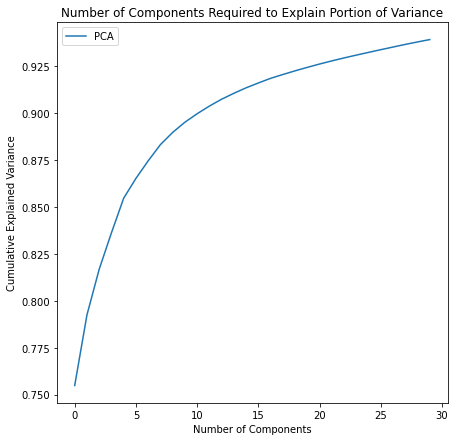

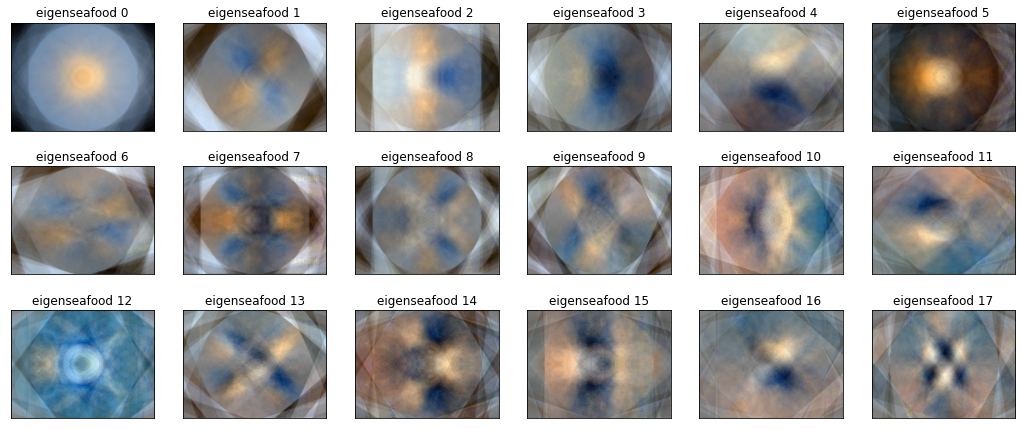

In [3]:
# PCA

from sklearn.decomposition import PCA

# n_components = 100
n_components = 30
pca = PCA(n_components=n_components)
%time pca.fit(data.copy())

eigenseafood = pca.components_.reshape((n_components, height, width, channels))
eigenseafood_titles = ["eigenseafood %d" % i for i in range(eigenseafood.shape[0])]
list_variance(pca)
plot_variance(PCA = pca)
plot_gallery(eigenseafood, eigenseafood_titles, height, width)

Wall time: 37.4 s
Dimensions required to explain...
50% of variance: 1
55% of variance: 2
60% of variance: 3
65% of variance: 4
70% of variance: 5
75% of variance: 6
80% of variance: 7
85% of variance: 8
90% of variance: 12


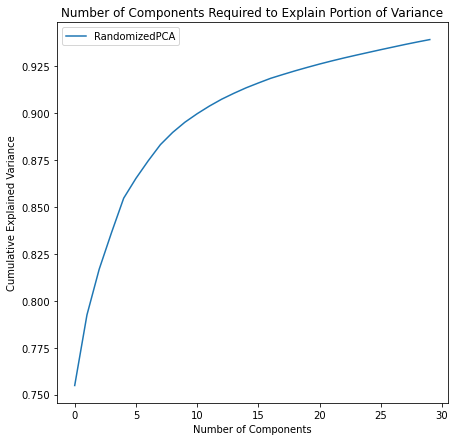

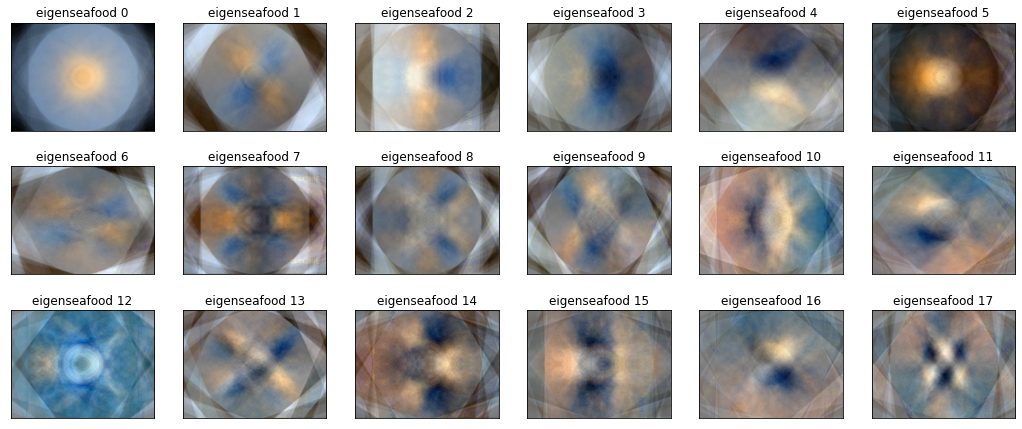

In [4]:
# Randomized PCA

from sklearn.decomposition import PCA

# n_components = 100
n_components = 30
rpca = PCA(n_components=n_components, svd_solver="randomized")
%time rpca.fit(data.copy())

eigenseafood = rpca.components_.reshape((n_components, height, width, channels))
eigenseafood_titles = ["eigenseafood %d" % i for i in range(eigenseafood.shape[0])]
list_variance(rpca)
plot_variance(RandomizedPCA = rpca)
plot_gallery(eigenseafood, eigenseafood_titles, height, width)

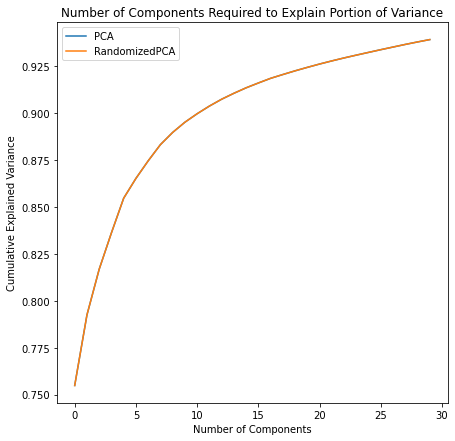

In [5]:
plot_variance(PCA = pca, RandomizedPCA = rpca)

In [49]:
# https://www.kaggle.com/ericlikedata/reconstruct-error-of-pca
from numpy import linalg as LA

max_comp=30
start=10
error_record=[]
for i in range(start, max_comp, 2):
    pca1 = PCA(n_components=i)
    pca2_results = pca1.fit_transform(data)
    pca2_proj_back=pca1.inverse_transform(pca2_results)
    total_loss=LA.norm((data - pca2_proj_back),None)
    error_record.append(total_loss)

pyplot.clf()
pyplot.figure(figsize=(8,8))
pyplot.title("Reconstruction Error of PCA and Randomized PCA")
pyplot.plot(error_record)
pyplot.xticks(range(len(error_record)), range(start, max_comp, 2), rotation='vertical')
pyplot.xlim([-1, len(error_record)])
pyplot.show()

MemoryError: Unable to allocate 2.63 GiB for an array with shape (1800, 196470) and data type float64